<a href="https://colab.research.google.com/github/mpky/abrams_project/blob/master/abrams_project_image_classification_20190421.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### M1 Abrams Image Classification

In this notebook, I will do the following:
  - Display a few sample images
  - Set up ImageDataGenerator to flow my image data into my model
  - Build the Convolutional Neural Network
  - Train the model over 200 epochs
  - Evaluate broader model performance
  - Observe how my model performs on four specific test images from combatant social media accounts. I.e. determine if my model can actually achieve what I have set out to achieve.

### Set up ngrok and Tensorboard

In [1]:
!ps

    PID TTY          TIME CMD
      1 ?        00:00:00 run.sh
      8 ?        00:00:00 node
     27 ?        00:00:00 node
     37 ?        00:00:01 jupyter-noteboo
    134 ?        00:00:00 tail
    143 ?        00:00:01 python3
    170 ?        00:00:00 ps


In [2]:
# Download and unzip ngrok in the runtime storage
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip

--2019-04-21 23:55:26--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 34.206.130.40, 34.204.22.7, 3.92.108.98, ...
Connecting to bin.equinox.io (bin.equinox.io)|34.206.130.40|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14977695 (14M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip’

ngrok-stable-linux- 100%[===================>]  14.28M  37.2MB/s    in 0.4s    

2019-04-21 23:55:27 (37.2 MB/s) - ‘ngrok-stable-linux-amd64.zip’ saved [14977695/14977695]

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   


In [0]:
# Run tensorboard
# LOG_DIR = 'content/gdrive/My Drive/Colab Notebooks/final_project/log'
LOG_DIR = './log'
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)

In [0]:
# Run ngrok to tunnel tensorboard port 6006
get_ipython().system_raw('./ngrok http 6006 &')

In [5]:
!ps

    PID TTY          TIME CMD
      1 ?        00:00:00 run.sh
      8 ?        00:00:00 node
     27 ?        00:00:00 node
     37 ?        00:00:01 jupyter-noteboo
    134 ?        00:00:00 tail
    143 ?        00:00:01 python3
    174 ?        00:00:01 tensorboard
    181 ?        00:00:00 ngrok
    193 ?        00:00:00 ps


In [6]:
# get the url for TB page
!curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

https://c8ed8df8.ngrok.io


In [7]:
!ps

    PID TTY          TIME CMD
      1 ?        00:00:00 run.sh
      8 ?        00:00:00 node
     27 ?        00:00:00 node
     37 ?        00:00:01 jupyter-noteboo
    134 ?        00:00:00 tail
    143 ?        00:00:01 python3
    174 ?        00:00:01 tensorboard
    181 ?        00:00:00 ngrok
    207 ?        00:00:00 ps


In [8]:
# The file I/O with Google Colab is a bit tricky, especially when interacting with Google Drive
# Need to mount Drive first to access files

from google.colab import drive
drive.mount('/content/gdrive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive/


In [9]:
# Navigate into the proper project folder
# %cd /content/gdrive/My\ Drive/Colab Notebooks
!pwd

/content


### Explore the image data

In [0]:
# Import a few libraries to be able to display sample images
import matplotlib.pyplot as plt
import cv2
%matplotlib inline
import seaborn as sns

In [0]:
# Create a function to display images

def display_image(image_filepath):
  image = cv2.imread(image_filepath)

  # cv2 reads images in in BGR, but matplotlib uses RGB
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  
  # Set a standard display size to deal with the different-sized images
  fig = plt.figure(figsize=(12,10))
  ax = fig.add_subplot(111)
  ax.grid(False)
  ax.imshow(image)
  return plt.show()


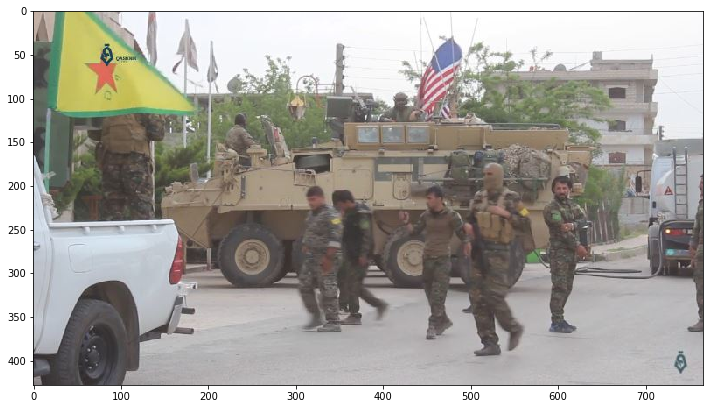

In [12]:
# A few sample images from both folders
# This is one that does not contain an M1 Abrams tank
display_image('/content/gdrive/My Drive/Colab Notebooks/final_project/abrams_not_abrams/train/not_abrams/YPG_and_US_army_Hassaka_1_5_2017.jpg')

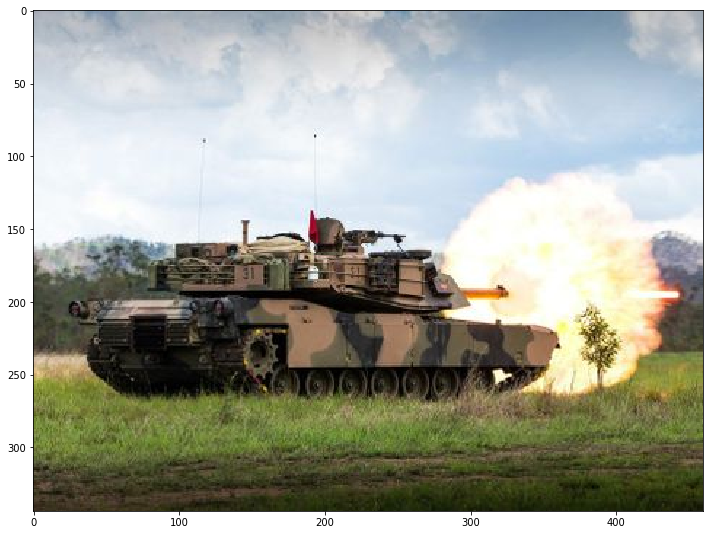

In [13]:
# An image with an M1 Abrams
display_image('/content/gdrive/My Drive/Colab Notebooks/final_project/abrams_not_abrams/train/abrams/9_4033795_twb171117corey2_fct923x692x19_t460.jpg')

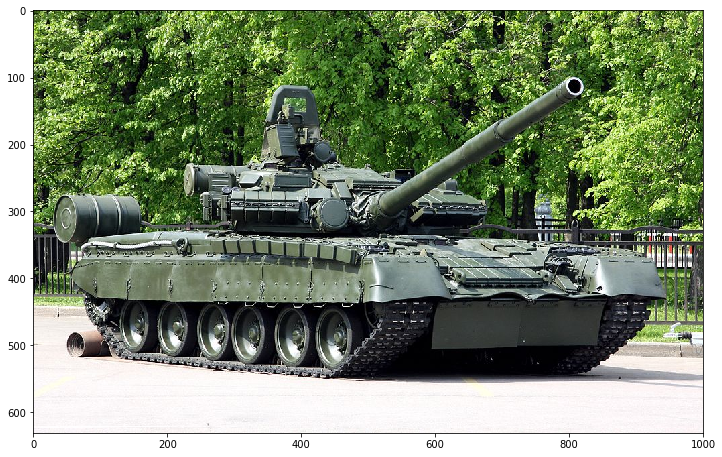

In [14]:
# A tank, but not an M1 Abrams
# Will help the model focus on the features of the M1 that make it distinct from other tanks
display_image('/content/gdrive/My Drive/Colab Notebooks/final_project/abrams_not_abrams/train/not_abrams/1000px_Russian_T_80BV.jpg')

### ImageDataGenerator

I've downloaded images of M1 Abrams tanks into two folders labeled "abrams" for training and testing and done the same for "not_abrams." I've done this in order to make use of Keras' ImageDataGenerator and .flow_from_directory() to handle my image files as well as label from the folder names. ImageDataGenerator also has some image distortion to add noise to images as it flows them in. I will make use of this to better learn my model.

In [15]:
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


In [0]:
# Set the parameters for adding "noise" to the images
image_gen = ImageDataGenerator(rotation_range=20, # slight rotation
                               width_shift_range=0.1, # randomly resizing images
                               height_shift_range=0.1,
                               rescale=1/255, 
                               shear_range=0.2, # crops out parts of the image
                               zoom_range=0.2,
                               horizontal_flip=True, # flip images along the horizontal axis
                               fill_mode='nearest'
                               )

In [17]:
# Now generate many images from the directory
image_gen.flow_from_directory('/content/gdrive/My Drive/Colab Notebooks/final_project/abrams_not_abrams/train')

Found 1489 images belonging to 2 classes.


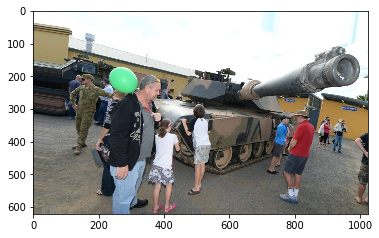

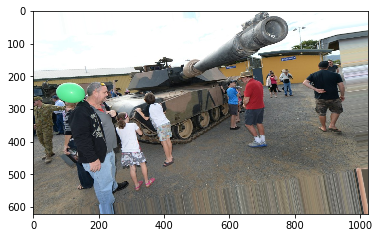

In [18]:
# Inspect how our data generator parameters are transforming our images
abrams = cv2.imread('/content/gdrive/My Drive/Colab Notebooks/final_project/abrams_not_abrams/train/abrams/9_2863556_rok050715ctalisman7_t1024.jpg')
abrams = cv2.cvtColor(abrams, cv2.COLOR_BGR2RGB)

plt.imshow(image_gen.random_transform(abrams))
plt.grid(False)
plt.show()

abrams = cv2.imread('/content/gdrive/My Drive/Colab Notebooks/final_project/abrams_not_abrams/train/abrams/9_2863556_rok050715ctalisman7_t1024.jpg')
abrams = cv2.cvtColor(abrams, cv2.COLOR_BGR2RGB)

plt.imshow(image_gen.random_transform(abrams))
plt.grid(False)
plt.show()

### CNN

In [19]:
# %cd /content/
!ls

gdrive	ngrok  ngrok-stable-linux-amd64.zip  sample_data


In [20]:
# Set batch size
batch_size = 16
input_shape = (150,150,3)

# Assign train_image_gen to input into .fit_generator
train_image_gen = image_gen.flow_from_directory('/content/gdrive/My Drive/Colab Notebooks/final_project/abrams_not_abrams/train',
                                                   target_size=input_shape[:2],
                                                   batch_size=batch_size,
                                                   class_mode='binary')

# test_image_gen will give us validation accuracy and loss on each epoch to see if the model is actually learning 
# or just overfitting on the training data
test_image_gen = image_gen.flow_from_directory('/content/gdrive/My Drive/Colab Notebooks/final_project/abrams_not_abrams/test',
                                                   target_size=input_shape[:2],
                                                   batch_size=batch_size,
                                                   class_mode='binary')

Found 1489 images belonging to 2 classes.
Found 470 images belonging to 2 classes.


In [0]:
# Build the Convolutional Neural Network
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Activation,Dense,Dropout,Flatten,Conv2D,MaxPooling2D
from tensorflow.keras.callbacks import TensorBoard
import pickle
import time

In [0]:
# Set image shape
# Larger values were beginning to take much more time to fit

# Name the model
# NAME = "abrams-vs-not-cnn-16-16-32-64-50epochs-{}".format(int(time.time()))

# tensorboard = TensorBoard(log_dir='/content/gdrive/My Drive/Colab Notebooks/final_project/log/{}'.format(NAME))
# tensorboard = TensorBoard(log_dir='./log/{}'.format(NAME))


Have to clear out the log folder for the tensorboard to look one directory deeper.

In [22]:
# print(tensorboard.log_dir)
!pwd

/content


In [23]:
dense_layers = [2]
layer_sizes = [64, 128]
conv_layers = [2, 3]

for dense_layer in dense_layers:
    for layer_size in layer_sizes:
        for conv_layer in conv_layers:
            NAME = "{}-conv-{}-nodes-{}-dense-{}".format(conv_layer, layer_size, dense_layer, int(time.time()))
            print(NAME)

            model = Sequential()
            model.add(Conv2D(16, (3,3), input_shape=input_shape, activation='relu'))
            model.add(MaxPooling2D(pool_size=(2,2)))

#             model.add(Conv2D(filters=16, kernel_size=(3,3), activation='relu'))
#             model.add(MaxPooling2D(pool_size=(2,2)))
#             model.add(Dropout(0.2))
            
            for l in range(conv_layer-1):

              model.add(Conv2D(layer_size, kernel_size=(3,3), activation='relu'))
              model.add(MaxPooling2D(pool_size=(2,2)))
              model.add(Dropout(0.2))

            model.add(Flatten())
            
            for l in range(dense_layer):
              model.add(Dense(layer_size))
              model.add(Activation("relu"))
            

            model.add(Dense(128))
            model.add(Activation("relu"))
            model.add(Dropout(0.5))

            model.add(Dense(1))
            model.add(Activation("sigmoid"))

            tensorboard = TensorBoard(log_dir='./log/{}'.format(NAME))

            model.compile(loss='binary_crossentropy',
                         optimizer='adam',
                         metrics=['accuracy'])

#             model.fit(X,y,batch_size=32,validation_split=0.3, 
#                       epochs=10, 
#                       callbacks=[tensorboard])

            results = model.fit_generator(train_image_gen,
                                          epochs=100,
                                          steps_per_epoch=32,
                                          validation_data=test_image_gen,
                                          validation_steps=10,
                                          callbacks=[tensorboard, ])
  
            model.save("{}-conv-{}-nodes-{}-dense-{}-CNN.model".format(conv_layer, layer_size, dense_layer, int(time.time())))

2-conv-64-nodes-2-dense-1555891034
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Epoch 1/100
32/32 [==============================] - 127s 4s/step - loss: 0.5400 - acc: 0.7793 - val_loss: 0.3736 - val_acc: 0.8438
Epoch 2/100
32/32 [==============================] - 133s 4s/step - loss: 0.5486 - acc: 0.7578 - val_loss: 0.4281 - val_acc: 0.7750
Epoch 3/100


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:914: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


32/32 [==============================] - 114s 4s/step - loss: 0.4351 - acc: 0.7791 - val_loss: 0.3717 - val_acc: 0.8667
Epoch 4/100
32/32 [==============================] - 8s 262ms/step - loss: 0.4894 - acc: 0.7852 - val_loss: 0.3716 - val_acc: 0.8625
Epoch 5/100
32/32 [==============================] - 10s 310ms/step - loss: 0.4678 - acc: 0.8105 - val_loss: 0.3483 - val_acc: 0.8187
Epoch 6/100
32/32 [==============================] - 10s 326ms/step - loss: 0.4787 - acc: 0.7693 - val_loss: 0.3487 - val_acc: 0.8400
Epoch 7/100
32/32 [==============================] - 10s 301ms/step - loss: 0.4357 - acc: 0.8047 - val_loss: 0.3522 - val_acc: 0.8625
Epoch 8/100
32/32 [==============================] - 10s 312ms/step - loss: 0.4632 - acc: 0.7773 - val_loss: 0.3014 - val_acc: 0.8688
Epoch 9/100
32/32 [==============================] - 8s 263ms/step - loss: 0.4632 - acc: 0.7810 - val_loss: 0.4141 - val_acc: 0.8267
Epoch 10/100
32/32 [==============================] - 10s 301ms/step - loss: 0

##### Old Model

In [26]:
# Build model
model = Sequential()

model.add(Conv2D(filters=16, kernel_size=(3,3), input_shape=input_shape, activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters=16, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))
# Dropout will help prevent overfitting and prevent any one node from dominating a prediction

model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())

model.add(Dense(128))
model.add(Activation('relu'))

model.add(Dropout(0.5))

model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [28]:
# Fit the model and assign to the results variable
# At ~30 seconds per epoch for 200 epochs, this will take some time to train
results = model.fit_generator(train_image_gen,
                              epochs=50,
                              steps_per_epoch=32,
                              validation_data=test_image_gen,
                              validation_steps=10,
                              callbacks=[tensorboard])

Instructions for updating:
Use tf.cast instead.
Epoch 1/50
32/32 [==============================] - 137s 4s/step - loss: 0.6069 - acc: 0.7559 - val_loss: 0.5911 - val_acc: 0.8438
Epoch 2/50
 6/32 [====>.........................] - ETA: 1:45 - loss: 0.5444 - acc: 0.7812

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:914: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


32/32 [==============================] - 130s 4s/step - loss: 0.5297 - acc: 0.7695 - val_loss: 0.5079 - val_acc: 0.8438
Epoch 3/50
32/32 [==============================] - 118s 4s/step - loss: 0.4937 - acc: 0.7889 - val_loss: 0.4401 - val_acc: 0.7933
Epoch 4/50
32/32 [==============================] - 10s 304ms/step - loss: 0.5017 - acc: 0.7637 - val_loss: 0.4360 - val_acc: 0.8812
Epoch 5/50
32/32 [==============================] - 9s 279ms/step - loss: 0.4542 - acc: 0.7910 - val_loss: 0.4164 - val_acc: 0.8187
Epoch 6/50
32/32 [==============================] - 10s 326ms/step - loss: 0.5330 - acc: 0.7624 - val_loss: 0.6129 - val_acc: 0.7867
Epoch 7/50
32/32 [==============================] - 11s 335ms/step - loss: 0.5476 - acc: 0.7676 - val_loss: 0.4639 - val_acc: 0.8250
Epoch 8/50
32/32 [==============================] - 9s 294ms/step - loss: 0.4413 - acc: 0.7910 - val_loss: 0.4417 - val_acc: 0.8250
Epoch 9/50
32/32 [==============================] - 9s 290ms/step - loss: 0.4642 - acc

In [0]:
# Given the issues with Google Colab and its runtime limitations, saving the model for later use is essential
model.save('abrams_not_abrams_200epochs.h5')

In [0]:
# Can access how the accuracy changed over each epoch from the results variable
results.history['acc']

[0.7783333333333333,
 0.7729957805907173,
 0.7721518987341772,
 0.7628691983122363,
 0.7966666666666666,
 0.7763713080168776,
 0.7974683544303798,
 0.7763713080168776,
 0.7805907172995781,
 0.7858333333333334,
 0.7890295358649789,
 0.7974683544303798,
 0.7924050632911392,
 0.8151898734177215,
 0.7941666666666667,
 0.7611814345991561,
 0.7789029535864979,
 0.7789029535864979,
 0.7856540084388186,
 0.8008333333333333,
 0.7890295358649789,
 0.8168776371308016,
 0.8067510548523207,
 0.790717299578059,
 0.8133333333333334,
 0.8042194092827004,
 0.7839662447257384,
 0.8050632911392405,
 0.8059071729957806,
 0.8066666666666666,
 0.809282700421941,
 0.8008438818565401,
 0.809282700421941,
 0.8025316455696202,
 0.8333333333333334,
 0.8160337552742616,
 0.8084388185654009,
 0.8168776371308016,
 0.8177215189873418,
 0.8325,
 0.8135021097046413,
 0.8345991561181435,
 0.8033755274261604,
 0.8236286919831224,
 0.835,
 0.829535864978903,
 0.8286919831223629,
 0.829535864978903,
 0.8337552742616033,
 

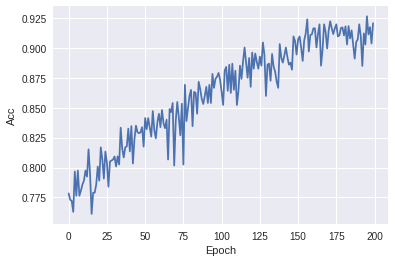

In [0]:
# Graph the progression of accuracy
# Good to see it improving as it progressed through the epochs
plt.plot(results.history['acc'])
plt.xlabel('Epoch')
plt.ylabel('Acc')
plt.show()

In [0]:
# Get the baseline class imbalance
# Necessary to check this way rather than counting from the folders since ImageDataGenerator may have been unable
# to use some of the images
print(len(train_image_gen.filenames))

abrams_count = 0
not_abrams_count = 0
for file in train_image_gen.filenames:
  if file.split('/')[0] == 'abrams':
    abrams_count += 1
  else:
    not_abrams_count += 1

# Print the counts of each class
print(abrams_count, not_abrams_count)


1489
1158 331


Considering the class imbalance for the training data is 331 images of not M1 Abrams and 1158 images of M1 Abrams tanks, the baseline performance for a model that guesses all "M1 Abrams" is .7777. On the final epoch, the model's accuracy was .9207, meaning it was definitely learning.

#### Testing Performance

Now I will check whether the model merely overfit to the training data or actually can detect M1 Abrams tanks by evaluating performance on the testing data.

In [37]:
!pwd

/content/gdrive/My Drive/Colab Notebooks/final_project


In [0]:
from keras.models import load_model
from keras.preprocessing import image
import numpy as np

# Load the saved model
loaded_model = load_model('/content/3-conv-64-nodes-2-dense-1555893339-CNN.model')

In [40]:
# Use .evaluate_generator() and test_image_gen to determine how the model performs on the testing data
filenames = test_image_gen.filenames
# Have to set steps to the number of files in the test folder
nb_samples = len(filenames)
loaded_model.evaluate_generator(test_image_gen,verbose=1,steps=nb_samples)

 35/470 [=>............................] - ETA: 1:30

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:914: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


470/470 [==============================] - 99s 210ms/step


[0.3242964589117986, 0.8570652172698275]

Given the class imbalance, baseline performance on the testing data is 0.8277. As we can see, the model beats this by ~4%, meaning it has indeed learned to detect an M1 Abrams to some extent.

Next, to get some topline statistics, I will need to manually get y_true and y_pred because of ImageDataGenerator

In [41]:
# First, get y_pred

y_pred = []
for file in test_image_gen.filenames:
  # NN will expect images in 150x150 so have to resize
  abrams_img = image.load_img('abrams_not_abrams/test/' + file,target_size=(150,150))
  abrams_img = image.img_to_array(abrams_img) # convert to array
  abrams_img = np.expand_dims(abrams_img, axis=0) # expand dimensions to fit NN
  
  abrams_img = abrams_img/255 # scale it for the model
  prediction = loaded_model.predict_classes(abrams_img)

  y_pred.append(prediction[0][0])
  

print(y_pred)
# Confirm it's the right length
print(len(y_pred))

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:914: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


[0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 

In [42]:
# Next, get y_true

abrams_count = 0
not_abrams_count = 0
for file in filenames:
  if file.split('/')[0] == 'abrams':
    abrams_count += 1
  else:
    not_abrams_count += 1

# Print the counts of each class so we know how to fill our y_true array
print(abrams_count, not_abrams_count)

y_true = np.array([0] * 389 + [1] * 81)
y_true

389 81


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [0]:
# Get statistics with sklearn's various functions
from sklearn.metrics import confusion_matrix, classification_report, f1_score, recall_score, precision_score, accuracy_score

In [44]:
print(confusion_matrix(y_true,y_pred))
print('Accuracy:')
print(accuracy_score(y_true,y_pred),'\n')
# Will use f1 score as there's a fair amount of class imbalance
print('F1 Score:')
print(f1_score(y_true,y_pred))

[[349  40]
 [ 32  49]]
Accuracy:
0.8468085106382979 

F1 Score:
0.5764705882352942


The model has more Type I errors or false positives than it does Type II errors (false negatives). Because of the class assignments from ImageDataGenerator, this means that my model is predicting 38 images with an M1 Abrams in them are "not Abrams" and 27 images without an M1 Abrams in them are "Abrams." Ideally, I would prefer my model do the opposite, as I would rather it miss fewer actual M1 Abrams at the expense of falsely assigning "Abrams" to images that are not. This is something to address in my next steps.

Now I want to visually inspect how it performs on a sampling of images.

In [0]:
# Make a function to predict specific images and provide confidence of the prediction

def abrams_predict(image_filepath, model):
  abrams_img = image.load_img(image_filepath,target_size=(150,150))
  abrams_img = image.img_to_array(abrams_img)
  
  # Need to change dimensions so it's a batch of 1 image
  abrams_img = np.expand_dims(abrams_img, axis=0)
  # Re-scale the pixel values
  abrams_img = abrams_img/255
  print('Class prediction:')
  print(model.predict_classes(abrams_img))
  print('Prediction %:')
  print(model.predict(abrams_img))

In [46]:
# Here's how ImageDataGenerator has read in and assigned the classes
print(test_image_gen.class_indices)

{'abrams': 0, 'not_abrams': 1}


Class prediction:
[[1]]
Prediction %:
[[0.5854703]]


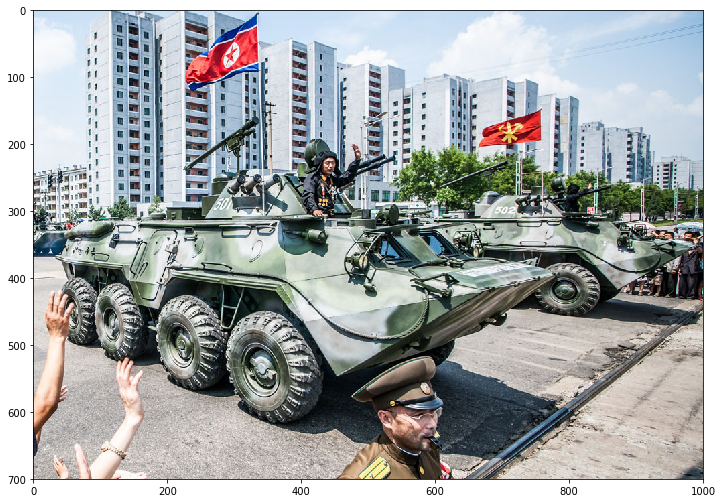

In [47]:
abrams_predict('abrams_not_abrams/test/not_abrams/8wh_m2010b.jpg',loaded_model)
display_image('abrams_not_abrams/test/not_abrams/8wh_m2010b.jpg')

Correctly predicted these APCs as "not Abrams" and did so with 92% confidence.

Class prediction:
[[1]]
Prediction %:
[[0.79893583]]


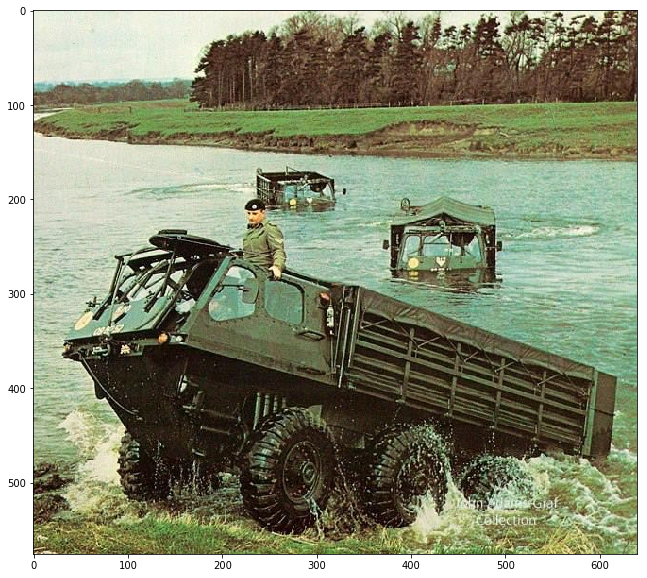

In [48]:
abrams_predict('abrams_not_abrams/test/not_abrams/007b904c4e78daaebdd4568278060e89__british_tanks_british_army.jpg',loaded_model)
display_image('abrams_not_abrams/test/not_abrams/007b904c4e78daaebdd4568278060e89__british_tanks_british_army.jpg')

The model was even more confident these trucks were not M1 Abrams tanks.

Class prediction:
[[0]]
Prediction %:
[[0.00716831]]


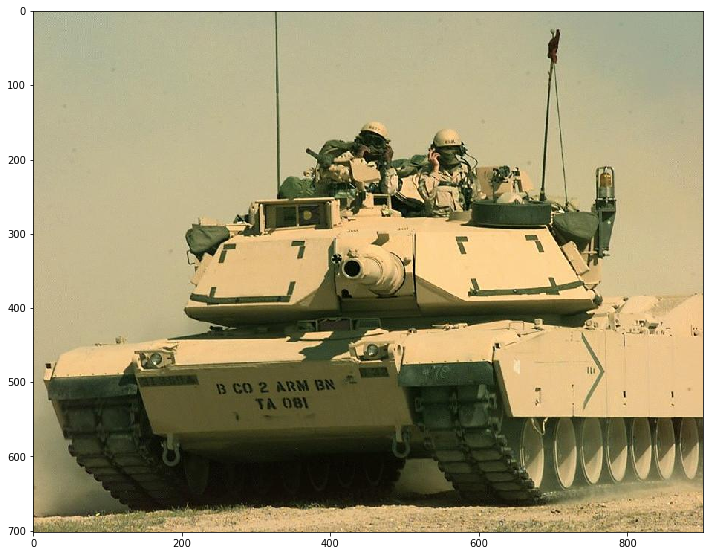

In [49]:
abrams_predict('abrams_not_abrams/test/abrams/m1a1_tankinmo 2.jpg',loaded_model)
display_image('abrams_not_abrams/test/abrams/m1a1_tankinmo 2.jpg')

For this image of an M1 Abrams, the model was extremely confident (>99.99999%) that this was an image of an M1 Abrams tank.

Class prediction:
[[0]]
Prediction %:
[[0.04434021]]


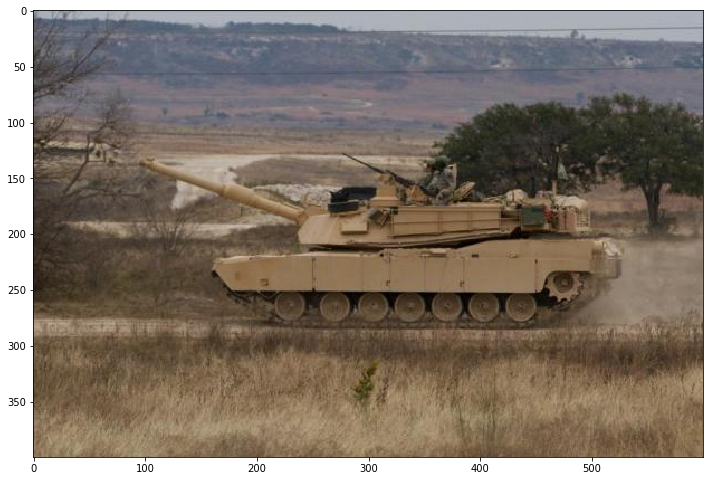

In [50]:
abrams_predict('abrams_not_abrams/test/abrams/US_Army_selects_General_Dynamics_for_Abrams_tank_production (1).jpg',loaded_model)
display_image('abrams_not_abrams/test/abrams/US_Army_selects_General_Dynamics_for_Abrams_tank_production (1).jpg')

It was also very confident this was an M1 Abrams tank, despite it being from the side. It is possible the model has picked up on the number of wheels or the distinct shape of the turret.

Class prediction:
[[1]]
Prediction %:
[[0.6193142]]


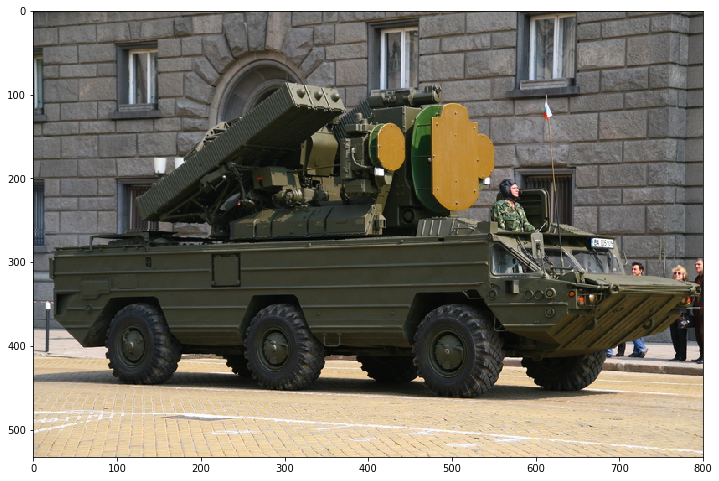

In [51]:
abrams_predict('abrams_not_abrams/test/not_abrams/Bulgarian_SA_8.jpg',loaded_model)
display_image('abrams_not_abrams/test/not_abrams/Bulgarian_SA_8.jpg')

The model got this one correct, but only barely.

The real images I care about are those from a few social media accounts of Iraq militia groups. This first one is from the video I mentioned as the genesis for this project. The group was showing off its equipment in a military parade and quickly panned over this M1 Abrams on the back of one of their trucks.

Class prediction:
[[0]]
Prediction %:
[[0.09777001]]


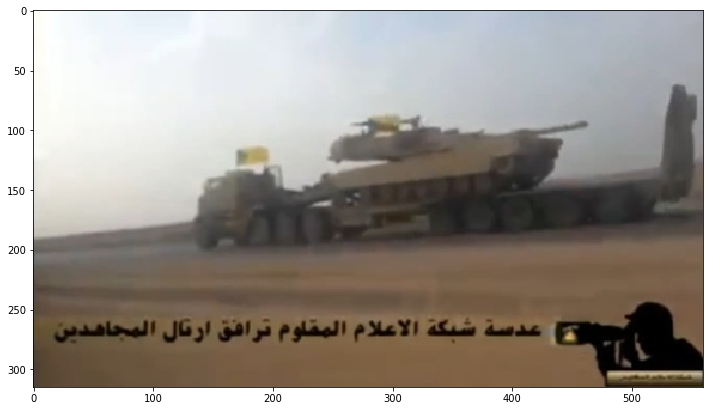

In [52]:
abrams_predict('abrams_not_abrams/KH_abrams_1.jpg',loaded_model)
display_image('abrams_not_abrams/KH_abrams_1.jpg')

A second image from a different militia group.

Class prediction:
[[0]]
Prediction %:
[[0.14334488]]


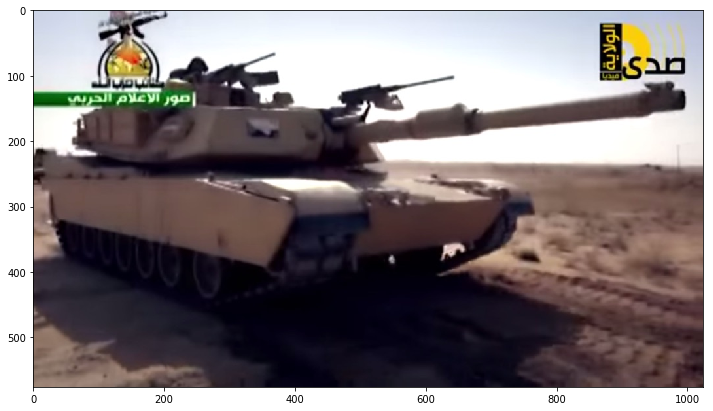

In [53]:
abrams_predict('abrams_not_abrams/KH_abrams_2_jpg.jpg',loaded_model)
display_image('abrams_not_abrams/KH_abrams_2_jpg.jpg')

Class prediction:
[[0]]
Prediction %:
[[0.19780527]]


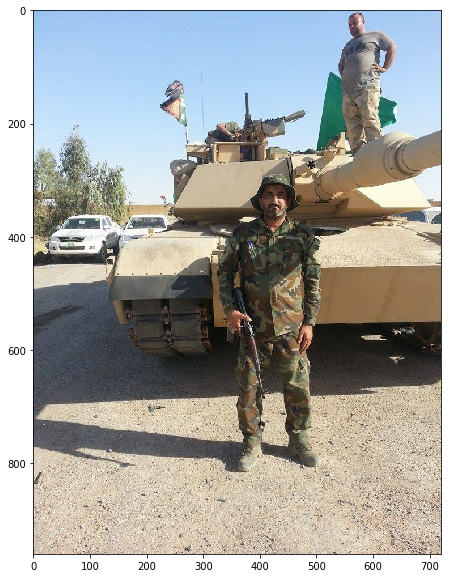

In [54]:
abrams_predict('abrams_not_abrams/badr_abrams_1.jpg',loaded_model)
display_image('abrams_not_abrams/badr_abrams_1.jpg')

Here the tank is partially occluded by the man, but the model is still able to correctly predict the M1 Abrams with a high degree of confidence.

Class prediction:
[[1]]
Prediction %:
[[0.6806185]]


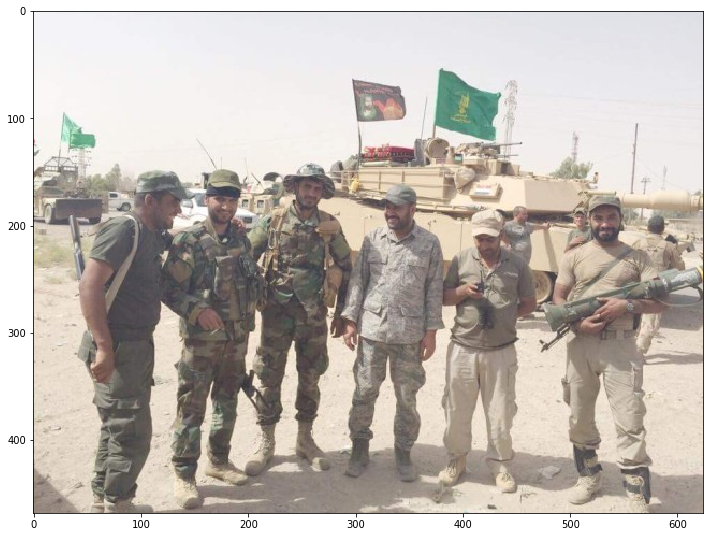

In [55]:
abrams_predict('abrams_not_abrams/badr_abrams_2.jpg',loaded_model)
display_image('abrams_not_abrams/badr_abrams_2.jpg')